# Исследование закономерности успешности игр в разных регионах
В нашем распоряжении данные интернет-магазина "Стримчик", который занимается продажами компьютерных игры по всему миру. Необходимо сделать ИА закономерности успешности игры, чтобы увеличить шанс выпустить популярную игру и окупить рекламную кампанию.

У нас имеются данные до 2016 года. Необходимо отобрать нужные данные для гипотез.

## Откроем файл с данными и изучим общую информацию.

### Ознакомление с датафреймом.

Импортируем библиотеку `pandas` и читаем данные датафрейма.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


In [12]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [13]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Выведем тип столбцов и объём датафрейма.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Вывод на экран список характерных значений.

In [15]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


## Предобработка данных.

### Изменим названия столбцов (приведём к нижнему регистру).

In [16]:
data = data.rename(columns={'Name': 'name', 'Platform': 'platform',
                            'Year_of_Release': 'year_of_release',
                            'Genre': 'genre',
                            'NA_sales': 'na_sales',
                            'EU_sales': 'eu_sales',
                            'JP_sales': 'jp_sales',
                            'Other_sales': 'other_sales',
                            'Critic_Score': 'critic_score',
                            'User_Score': 'user_score',
                            'Rating': 'rating'})

### Обработка пропусков в столбцах.
Выведем пропущенные значения для каждого столбца.

In [17]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [18]:
# check
def isna_view (df):
    return  (
                (df.isna().mean()*100)
                .sort_values(ascending=False)
                .to_frame()
                .rename(columns = {0:'percent_space'})
                .style.background_gradient('coolwarm').format("{:.1f}")
            )

isna_view (data)

,percent_space
critic_score,51.3
rating,40.5
user_score,40.1
year_of_release,1.6
name,0.0
genre,0.0
platform,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0


Удалим 2 пропущенных значения в колонке `name` и `genre`, т.к. название мы не можем придумать и жанр тоже. 2 значения никак не повлияют на выборку из всего датафрейма.

In [19]:
display(data[data['name'].isnull()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [20]:
data = data.dropna(subset=['name']) 

Заменим значение аббревиатуры `tbd` в столбце на значение `Nan`. TDB - аббревиатура 'To Be Determined (будет определено)'. Оно испольщуется, если какая-то информация ещё не определена. Служит для отметки пропусков, которые необходимо заполнить.

In [21]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

- Заполнить пропуски в столбце `rating` зачениями из записей с тем же типом мы не можем, т.к. у каждого жанра есть свои возрастные ограничения. Получается, что один и тот же жанр может иметь рейтинг `E` и `AO`. Следовательно мы не можем заполнять одинаковые жанры одинаковым рейтингом.
- Столбцы `critic_score` и `user_score` заполнять какими-либо мединными/средними значениями не стоит, т.к. пропусков в этих столбцах слишком много (больше 30% от всего датафрейма). Когда будем формулировать гипотезы эти значения могут сильно повлиять на наши исследования.
- `year_of_release` можно заполнить значением сильно отличающимся от значений этого слолбца (например 1850-1900), чтоб при дальнейшем исследовании сразу было видно эти аномалии.



Причины , которые могли привести к пропускам - отсутсвие проверки заполнения ячеек, либо неправильный перенос/копирование данных.

### Изменение типов данных.
- `year_of_release` - поменяем с `float64` на целочисленное, т.к. год не может быть 2007.43.
- `user_score` - поменяем с `object` на `float64`, т.к. оценка может быть с плавающим числом.

In [22]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

data['user_score'] = data['user_score'].astype('float64')

Проверим, что тип данных изменился.

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


### Посчитаем суммарные продажи во всех регионах.

Суммируем колонки `na_sales, eu_sales, jp_sales, other_sales` в одну общую.

In [24]:
data['overall_sales'] = data.iloc[:, 4:8].sum(axis=1)

In [25]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,overall_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [26]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
 11  overall_sales    16713 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


In [27]:
data['rating'] = data['rating'].fillna('undefined')

In [28]:
data.rating.unique()

array(['E', 'undefined', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

## Проведём исследовательский анализ данных.

###  Посмотрим, сколько игр выпускалось в разные года.

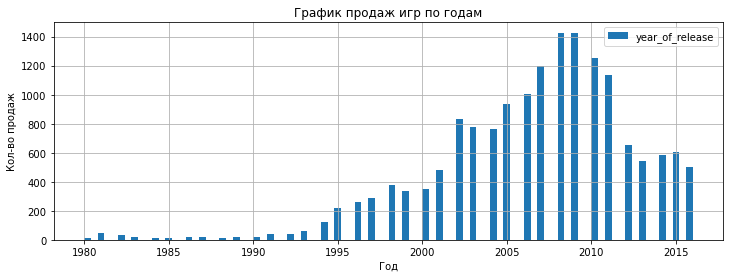

In [29]:
ax = data.plot(y=['year_of_release'], bins=90, kind='hist', figsize=(12,4), grid=True)
ax.set_xlabel('Год')
ax.set_ylabel('Кол-во продаж')
ax.set_title('График продаж игр по годам');

Начиная с 2001 года ежегодный выпуск игр стабильно растёт вплоть до 2011 года. Затем мы видим сильную просадку в производстве, но она остаётся выше значений 2001. Поэтому важные данные нас интересуют с 2001 года.

---

### Посмотрим как менялись продажи по платформам. 

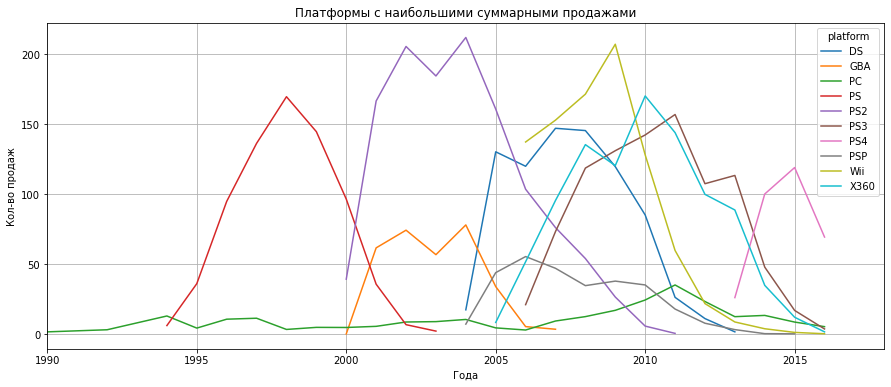

In [30]:
# группируем платформы и сортируем платформы по продажам в порядке убывания
grouped_platforms = data.groupby('platform')['overall_sales'].sum().sort_values(ascending = False).head(10)
# делаем список из отсортированных платформ и записываем в переменную
list_top_platforms = grouped_platforms.index.values.tolist()
# делаем датафрейм топ платформ из списка
top_platforms_df = data.query('platform in @list_top_platforms')

# сделаем сводную таблицу
pivot_top_platforms = top_platforms_df.pivot_table(index='platform', columns='year_of_release',
                                                   values='overall_sales', aggfunc='sum')
# транспонируем пивот, чтоб year_of_release стала колонкой
pivot_top_platforms_t = pivot_top_platforms.T

# строим график
ax = pivot_top_platforms_t.plot(
        figsize=(15,6),
        grid=True)
ax.set_title('Платформы с наибольшими суммарными продажами')
ax.set_xlabel('Года')
ax.set_ylabel('Кол-во продаж')
plt.xlim([1990, 2018]);

По графику видно, что среднее время появления новых и исчезания старых платформ около 8-10 лет. Платформа PC - хоть находится не на пике продаж по годам, зато самая стабильная, пришла издалека и уходит в будущее.

---

### Возьмём данные для актуального периода.
Актуальный период - последние 5 лет.

In [31]:
last_five_year_period_df = data[(data['year_of_release'] >= 2012)]
last_five_year_period_df.year_of_release.unique()

<IntegerArray>
[2013, 2015, 2012, 2014, 2016]
Length: 5, dtype: Int64

---

### Какие платформы лидируют по продажам, растут или падают? 

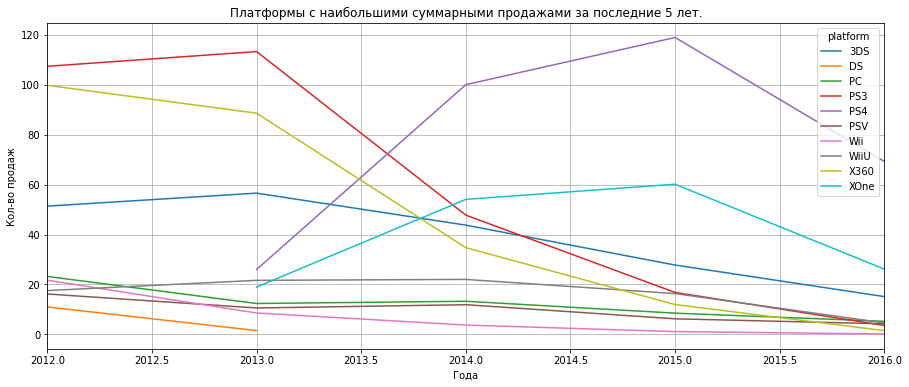

In [32]:
# группируем платформы и сортируем платформы по продажам в порядке убывания за последние 5 лет
grouped_platforms_last_five_years = last_five_year_period_df.groupby('platform')['overall_sales'].sum().sort_values(ascending = False).head(10)
# делаем список из отсортированных платформ и записываем в переменную
list_top_platforms_last_five_years = grouped_platforms_last_five_years.index.values.tolist()
# делаем датафрейм топ платформ из списка
top_platforms_last_five_years_df = last_five_year_period_df.query('platform in @list_top_platforms_last_five_years')

# сделаем сводную таблицу
pivot_top_platforms_last_five_years = top_platforms_last_five_years_df.pivot_table(index='platform',
                                                    columns='year_of_release', values='overall_sales', aggfunc='sum')
# транспонируем пивот, чтоб year_of_release стала колонкой
pivot_top_platforms_last_five_years_t = pivot_top_platforms_last_five_years.T

# строим график
ax = pivot_top_platforms_last_five_years_t.plot(
        figsize=(15,6),
        grid=True)
ax.set_title('Платформы с наибольшими суммарными продажами за последние 5 лет.')
ax.set_xlabel('Года')
ax.set_ylabel('Кол-во продаж')
plt.xlim([2012, 2016]);

Актуальный период возьмём с `2012 года`. Последние 5 лет дадут более точные прогнозы на будущее.

Из графика "Платформы с наибольшими суммарными продажами за последние 5 лет." можно сделать вывод, что лидирующие платформы это `PS4, XOne, 3DS`. Данные показывают, что идёт тенденация снижения продаж, но эти производители являются лидерами среди топовых платформ.

---

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

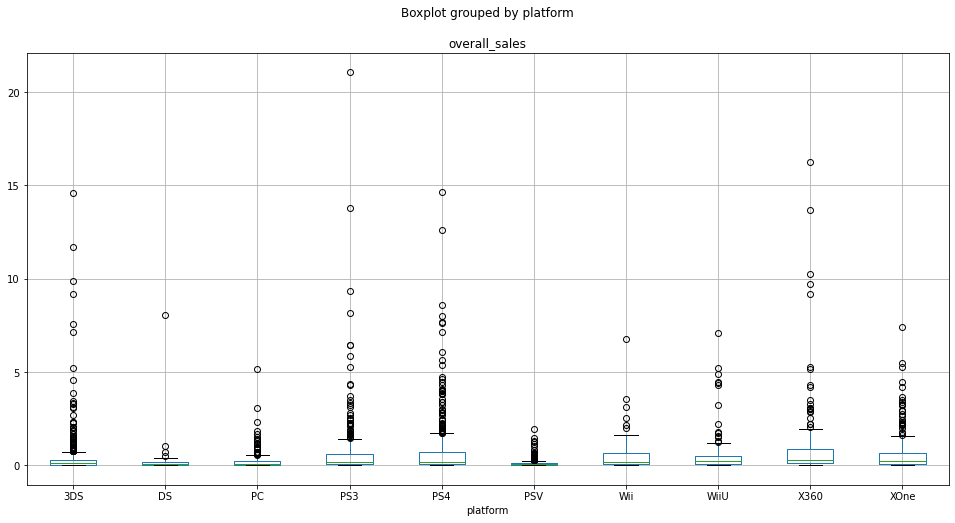

In [33]:
ax = last_five_year_period_df.query('platform in @list_top_platforms_last_five_years')   
ax.boxplot(
    'overall_sales',
    by='platform',
    grid = True,
    figsize=(16,8)
);

Из графика можно сделать вывод, что все платформы находятся примерно в едином диапазоне по продажам. Пики (выбросы) по продажам проявляются в основном у линейки производителя `PlayStation` разных поколений.

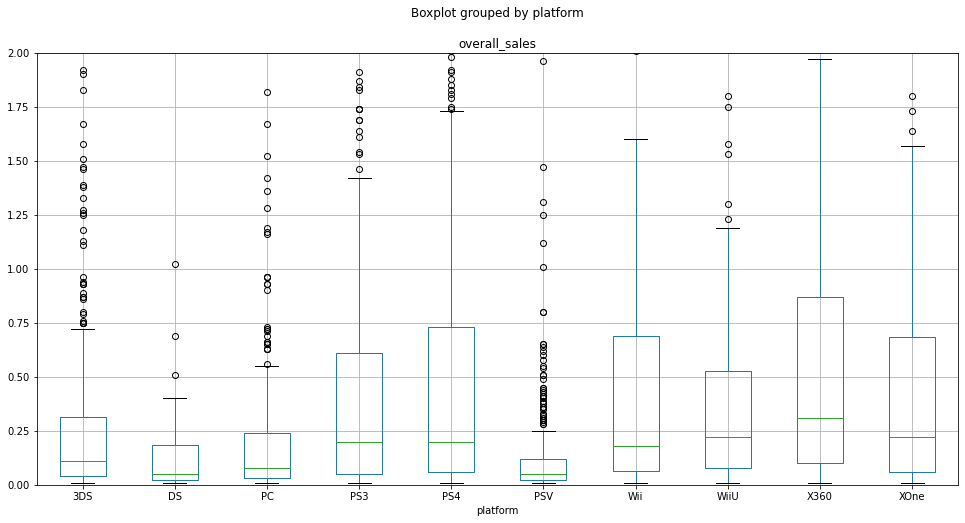

In [34]:
ax = last_five_year_period_df.query('platform in @list_top_platforms_last_five_years')   
ax.boxplot(
    'overall_sales',
    by='platform',
    grid = True,
    figsize=(16,8)
)
plt.ylim(0, 2);

---

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
Постром диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [35]:
# выберем популярную платформу по сумме продаж PS3
popular_platform = last_five_year_period_df.pivot_table(index='platform', values='overall_sales', aggfunc='count').reset_index()
popular_platform.sort_values(by='overall_sales', ascending = False).head(10)

,platform,overall_sales
3,PS3,493
6,PSV,411
0,3DS,396
4,PS4,392
9,X360,292
2,PC,250
10,XOne,247
5,PSP,173
8,WiiU,147
7,Wii,54


Коэффициент Пирсона 0.0 - нет линейной зависимости.


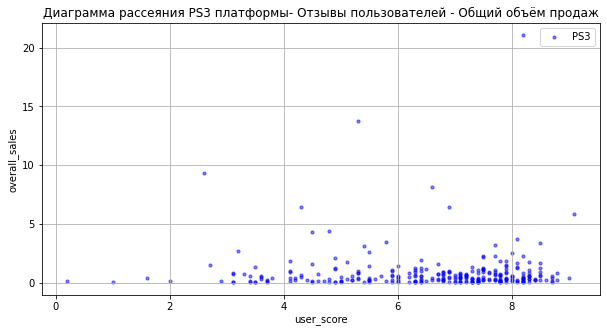

In [36]:
# график по отзывам пользователей
last_five_year_period_df[last_five_year_period_df['platform'] == 'PS3'].plot(
    kind='scatter', y='overall_sales', x='user_score', 
    alpha=0.5, figsize=(10,5), c = 'b', s = 10, grid=True,
    label = 'PS3')
plt.title('Диаграмма рассеяния PS3 платформы- Отзывы пользователей - Общий объём продаж')
print(f'Коэффициент Пирсона {last_five_year_period_df["overall_sales"].corr(last_five_year_period_df["user_score"]).round(decimals=2)} - нет линейной зависимости.');

Коэффициент Пирсона 0.31 - умеренная линейная зависимость.


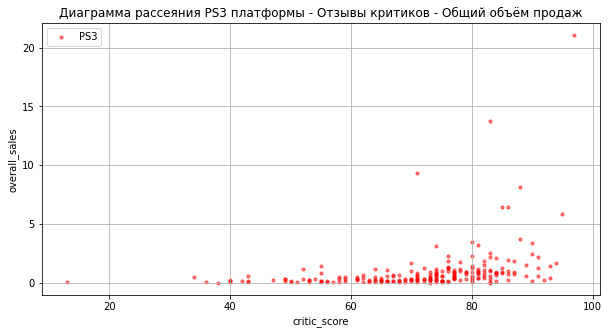

In [41]:
# график по отзывам пользователей
last_five_year_period_df[last_five_year_period_df['platform'] == 'PS3'].plot(
    kind='scatter', y='overall_sales', x='critic_score',
    alpha=0.5, figsize=(10,5), c = 'r', s = 10, grid=True,
    label = 'PS3')
plt.title('Диаграмма рассеяния PS3 платформы - Отзывы критиков - Общий объём продаж')

x = last_five_year_period_df["overall_sales"]\
.corr(last_five_year_period_df["critic_score"]).round(decimals=2)

print((f'Коэффициент Пирсона {x} - умеренная линейная зависимость.'));

Из графиков видно, что оценки пользователей и критиков во многом совпадают. Корреляция между оценками пользователей и количеством продаж равно 0, а вот оценка критиков имеет умеренное влияние на продажу.

AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


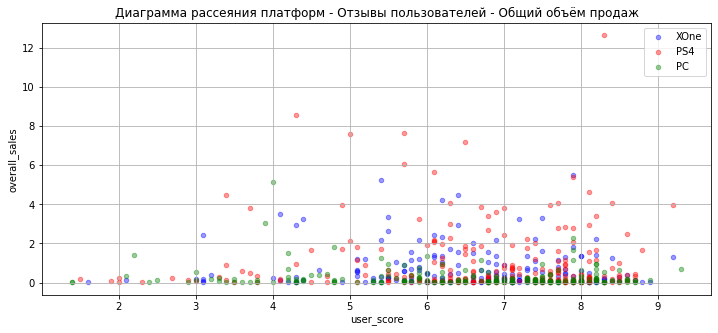

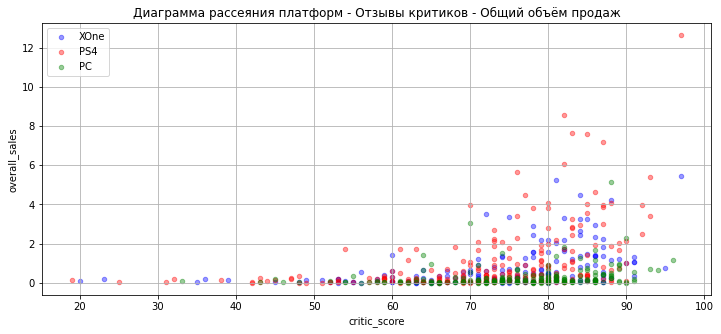

In [42]:
# диаграмма рассеяния пользователей
ax1 = last_five_year_period_df[last_five_year_period_df['platform'] == 'XOne'].plot(
    kind='scatter', y='overall_sales', x='user_score',
    alpha=0.4, figsize=(5,5), c = 'b', s = 20, grid=True, label = 'XOne');

ax2 = last_five_year_period_df[last_five_year_period_df['platform'] == 'PS4'].plot(
    kind='scatter', y='overall_sales', x='user_score',
    alpha=0.4, figsize=(12,5), c = 'r', s = 20, grid=True, ax=ax1, label='PS4');

ax3 = last_five_year_period_df[last_five_year_period_df['platform'] == 'PC'].plot(
    kind='scatter', y='overall_sales', x='user_score',
    alpha=0.4, figsize=(12,5), c = 'g', s = 20, grid=True, ax=ax1, label='PC');

plt.title('Диаграмма рассеяния платформ - Отзывы пользователей - Общий объём продаж');
print(ax1 , ax2, ax3);

# диаграмма рассеяния критиков
ax4 = last_five_year_period_df[last_five_year_period_df['platform'] == 'XOne'].plot(
    kind='scatter', y='overall_sales', x='critic_score',
    alpha=0.4, figsize=(5,5), c = 'b', s = 20, grid=True, label = 'XOne');

ax5 = last_five_year_period_df[last_five_year_period_df['platform'] == 'PS4'].plot(
    kind='scatter', y='overall_sales', x='critic_score',
    alpha=0.4, figsize=(12,5), c = 'r', s = 20, grid=True, ax=ax4, label='PS4');

ax6 = last_five_year_period_df[last_five_year_period_df['platform'] == 'PC'].plot(
    kind='scatter', y='overall_sales', x='critic_score',
    alpha=0.4, figsize=(12,5), c = 'g', s = 20, grid=True, ax=ax4, label='PC');

plt.title('Диаграмма рассеяния платформ - Отзывы критиков - Общий объём продаж');
print(ax4, ax5, ax6);

---

### Посмотрим на общее распределение игр по жанрам.

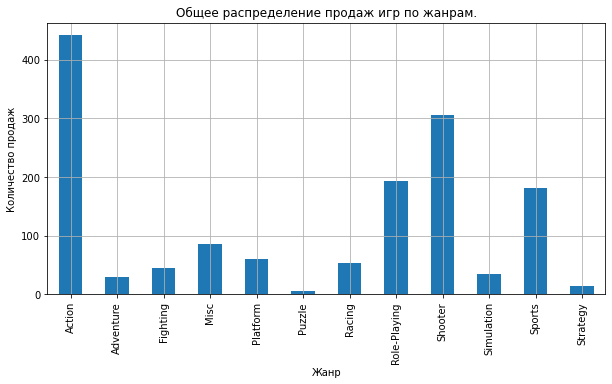

In [43]:
ax = last_five_year_period_df.groupby('genre')['overall_sales'].sum()
ax.plot(
    kind='bar',
    y='genre',
    grid=True,
    figsize=(10,5),
    title='Общее распределение продаж игр по жанрам.',
    xlabel='Жанр',
    ylabel='Количество продаж'
);

Самыми прибыльными жанрами и популярными по продажам являются `Action, Shooter, RP, Sports`. Также выделяются жанры с низкими продажами такие как `Puzzle, Adventure, Strategy`. Из этого графика можно сделать вывод, что усидчивость и вдумчивость нынче не в моде.

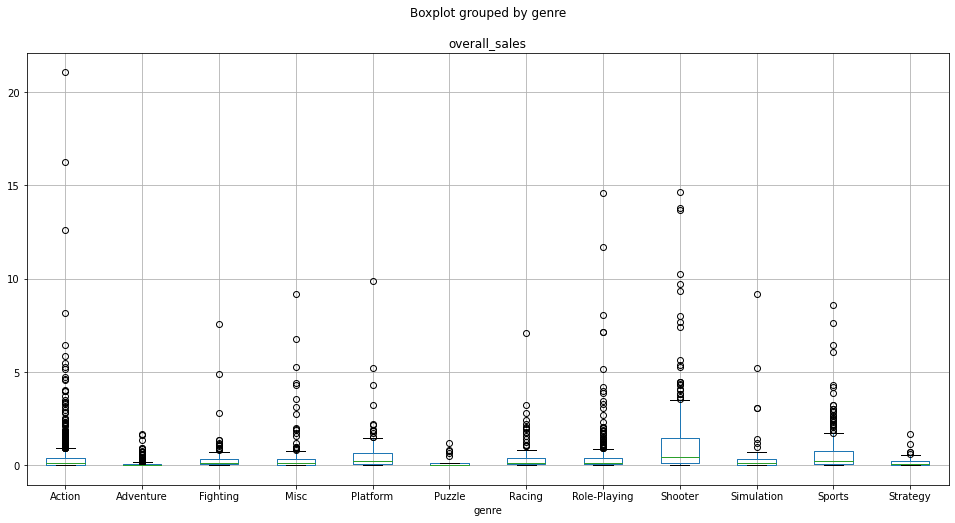

In [44]:
last_five_year_period_df.boxplot(
    'overall_sales',
    by='genre',
    grid = True,
    figsize=(16,8)
);

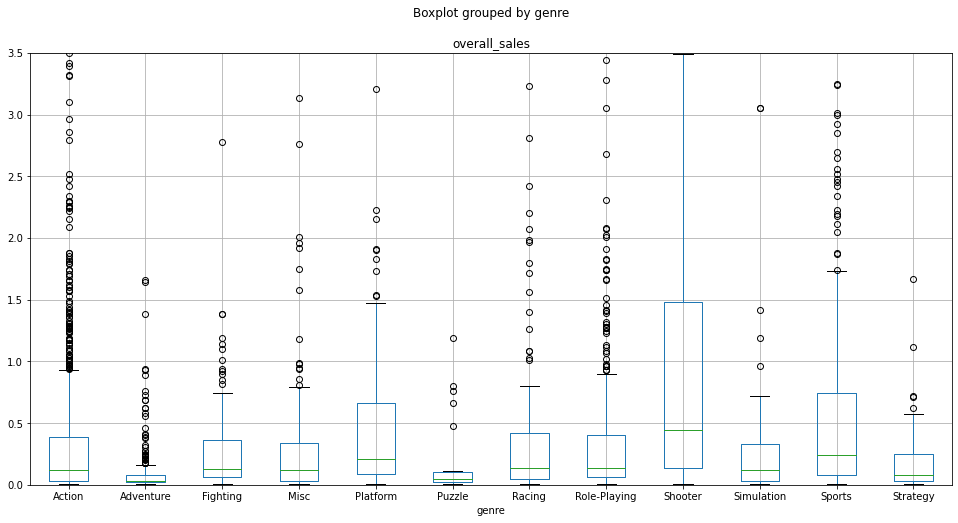

In [45]:
last_five_year_period_df.boxplot(
    'overall_sales',
    by='genre',
    grid = True,
    figsize=(16,8)
)
plt.ylim(0, 3.5);

---

## Составляем портрет пользователя каждого региона.

**Определим для пользователя каждого региона (NA, EU, JP):**

### Самые популярные платформы (топ-5). Опишем разлчия в долях продаж.

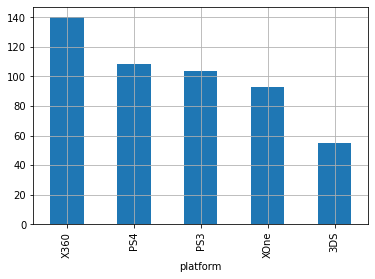

In [46]:
na_platform = last_five_year_period_df.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head(5)
na_platform.plot(kind='bar', grid=True);

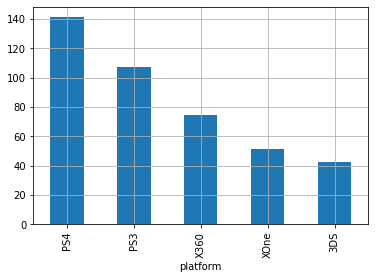

In [47]:
eu_platform = last_five_year_period_df.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head(5)
eu_platform.plot(kind='bar', grid=True);

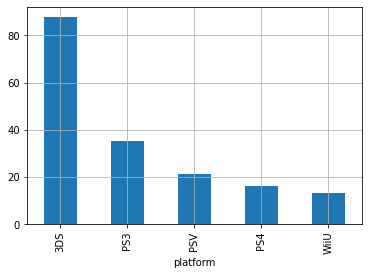

In [48]:
jp_platform = last_five_year_period_df.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head(5)
jp_platform.plot(kind='bar', grid=True);

Самым большим рынком по покупкам разных платформ является Северна Америка (NA). Япония же в свою очередь находится на последнем месте по объёмам покупок, в середине обосновалась Европе. Лидерами продаж являются платформы `PS4 и PS3` - их покупают в каждой стране.

### Самые популярные жанры (топ-5).

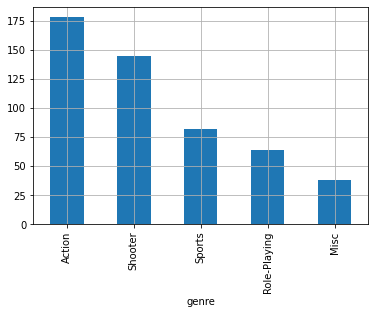

In [49]:
na_genre = last_five_year_period_df.groupby('genre')['na_sales'].sum().sort_values(ascending = False).head(5)
na_genre.plot(kind='bar', grid=True);

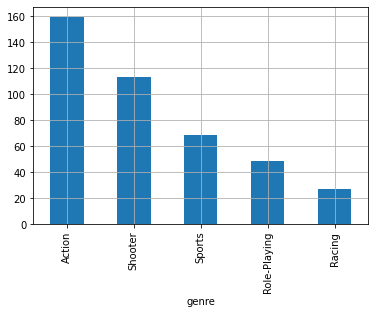

In [50]:
eu_genre = last_five_year_period_df.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head(5)
eu_genre.plot(kind='bar', grid=True);

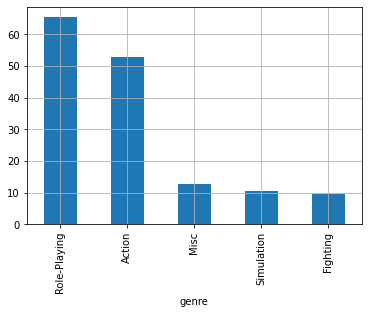

In [51]:
jp_genre = last_five_year_period_df.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head(5)
jp_genre.plot(kind='bar', grid=True);

Япония занимает опять же последнее место по количеству покупаемых игр на различные платформы. Самыми популярными жанрами среди всех стран являются `Action и Shooter`. Несмотря на то, что жанр `Shooter` отсутствует в топ покупках у Японии, количество продаж в странах Евпропы и Северной Америки совокупно выше, чем лидирующй жанр у Японии `Role-Playing`.

In [52]:
# создаём отдельный датафрейм с топ жанрами и платформами по регионам
top_regions_pl_gn = pd.DataFrame().assign(top_na_pl=last_five_year_period_df['platform'],
                                          top_eu_pl=last_five_year_period_df['platform'],
                                          top_jp_pl=last_five_year_period_df['platform'],
                                          top_na_gn=last_five_year_period_df['genre'],
                                          top_eu_gn=last_five_year_period_df['genre'],
                                          top_jp_gn=last_five_year_period_df['genre'],
                                          na_sales=last_five_year_period_df['na_sales'],
                                          eu_sales=last_five_year_period_df['eu_sales'],
                                          jp_sales=last_five_year_period_df['jp_sales'])

# группируем данные по платформам для каждого региона
grouped_na_platform = top_regions_pl_gn.groupby('top_na_pl')['na_sales'].sum().sort_values(ascending = False).head(5)
grouped_eu_platform = top_regions_pl_gn.groupby('top_eu_pl')['eu_sales'].sum().sort_values(ascending = False).head(5)
grouped_jp_platform = top_regions_pl_gn.groupby('top_jp_pl')['jp_sales'].sum().sort_values(ascending = False).head(5)
# группируем данные по платформам для каждого региона
grouped_na_genre = top_regions_pl_gn.groupby('top_na_gn')['na_sales'].sum().sort_values(ascending = False).head(5)
grouped_eu_genre = top_regions_pl_gn.groupby('top_eu_gn')['eu_sales'].sum().sort_values(ascending = False).head(5)
grouped_jp_genre = top_regions_pl_gn.groupby('top_jp_gn')['jp_sales'].sum().sort_values(ascending = False).head(5)


# создаём список из топ платформ по каждому региону
grouped_na_list_p = grouped_na_platform.index.values.tolist()
grouped_eu_list_p = grouped_eu_platform.index.values.tolist()
grouped_jp_list_p = grouped_jp_platform.index.values.tolist()
# создаём список из топ платформ по каждому региону
grouped_na_list_g = grouped_na_genre.index.values.tolist()
grouped_eu_list_g = grouped_eu_genre.index.values.tolist()
grouped_jp_list_g = grouped_jp_genre.index.values.tolist()


# изменяим значения для платформ, что не входят в топ5 
top_regions_pl_gn.loc[~top_regions_pl_gn['top_na_pl'].isin(grouped_na_list_p), 'top_na_pl'] = 'other'
top_regions_pl_gn.loc[~top_regions_pl_gn['top_eu_pl'].isin(grouped_eu_list_p), 'top_eu_pl'] = 'other'
top_regions_pl_gn.loc[~top_regions_pl_gn['top_jp_pl'].isin(grouped_jp_list_p), 'top_jp_pl'] = 'other'
# изменяим значения для жанров, что не входят в топ5 
top_regions_pl_gn.loc[~top_regions_pl_gn['top_na_gn'].isin(grouped_na_list_g), 'top_na_gn'] = 'other'
top_regions_pl_gn.loc[~top_regions_pl_gn['top_eu_gn'].isin(grouped_eu_list_g), 'top_eu_gn'] = 'other'
top_regions_pl_gn.loc[~top_regions_pl_gn['top_jp_gn'].isin(grouped_jp_list_g), 'top_jp_gn'] = 'other'

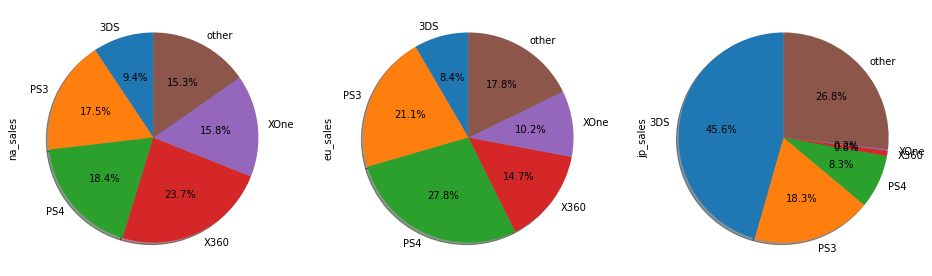

In [53]:
fig = top_regions_pl_gn.groupby(['top_na_pl']).sum().plot(kind='pie', subplots=True, shadow = True, legend = False, 
                                                                startangle=90, figsize=(16,10), autopct='%1.1f%%');


In [55]:
# check
top_regions_pl_gn.groupby(['top_na_pl']).sum()

,na_sales,eu_sales,jp_sales
top_na_pl,,,
3DS,55.31,42.64,87.79
PS3,103.38,106.86,35.29
PS4,108.74,141.09,15.96
X360,140.05,74.52,1.57
XOne,93.12,51.59,0.34
other,90.37,90.12,51.63


In [56]:
# check
top_regions_pl_gn.groupby(['top_jp_pl']).sum()

,na_sales,eu_sales,jp_sales
top_jp_pl,,,
3DS,55.31,42.64,87.79
PS3,103.38,106.86,35.29
PS4,108.74,141.09,15.96
PSV,10.98,11.36,21.04
WiiU,38.10,25.13,13.01
other,274.46,179.74,19.49


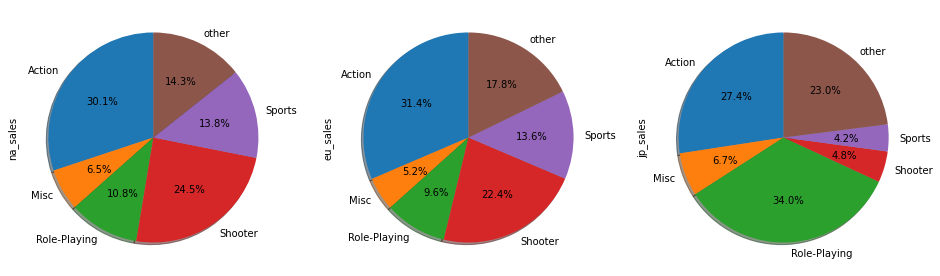

In [57]:
top_regions_pl_gn.groupby(['top_na_gn']).sum().plot(kind='pie', subplots=True, shadow = True, legend = False,
                                                    startangle=90, figsize=(16,10), autopct='%1.1f%%');

### Влияние рейтинга ESRB на продажми в отдельных регионах.

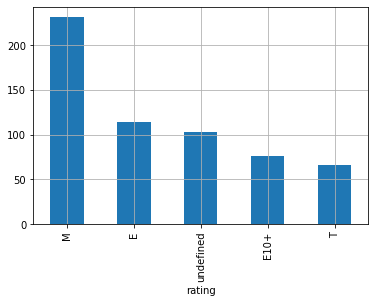

In [59]:
na_rating = last_five_year_period_df.groupby('rating')['na_sales'].sum().sort_values(ascending = False).head(5)
na_rating.plot(kind='bar', grid=True);

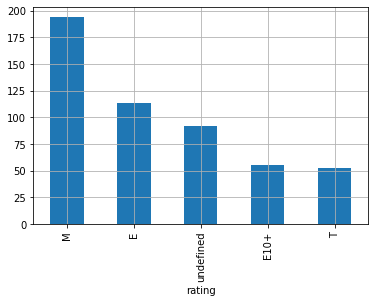

In [60]:
eu_rating = last_five_year_period_df.groupby('rating')['eu_sales'].sum().sort_values(ascending = False).head(5)
eu_rating.plot(kind='bar', grid=True);

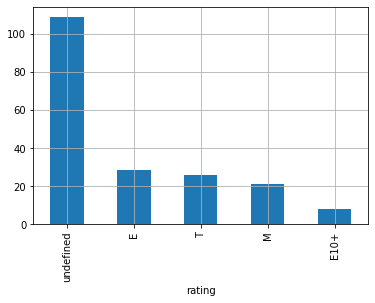

In [61]:
jp_rating = last_five_year_period_df.groupby('rating')['jp_sales'].sum().sort_values(ascending = False).head(5)
jp_rating.plot(kind='bar', grid=True);

В Европе и Северной Америке топ продаваемых игр по рейтингу ESRB совпадает, различается лишь объём продаж. Популярностью пользуются жанры с 17+ лет и для всех возрастов.Япония в свою очередь имеет другой топ лист, она более ориентирована на продажу игр в общей массе для всех возростных категорий и 13+. Нельзя прямо сказать, что рейтинг влияет на продажи игр, но можно предположить, что больше влияет менталитет стран на выбор жанров.

## Проверка гипотез.

**Чтобы проверить гипотезы нам необходимо подготовить датафрейм без пропусков в столбце `user_score`.**

In [62]:
filtered_df = last_five_year_period_df[last_five_year_period_df['user_score'].notnull()]

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Гипотезы:

- H_0 - Средние пользовательские рейтинги платформ *Xbox One и PC* одинаковые
- H_1 - Средние пользовательские рейтинги платформ *Xbox One и PC* разные
- alpha = 0.05

Выборки не зависят друг от друга.

In [63]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
results = st.ttest_ind(
    filtered_df.loc[(filtered_df['platform'] == 'XOne'), 'user_score'],
    filtered_df.loc[(filtered_df['platform'] == 'PC'), 'user_score'],
    equal_var = False)

# критический уровень значимости
alpha = .05

# выведите на экран получившееся p-значение
print('p-значение:', results.pvalue) 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Вероятность получить схожие результаты довольно высока, поэтому нулевая гипотеза, что средние показатаельские рейтинги платформ XOne и PC одинаковые - имеет высокую вероятность оказаться правдой. Поэтому нулевую гипотезу не отвергаем.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


Гипотезы:

- H_0 - Средние пользовательские рейтинги жанров *Action и Sports* одинаковые
- H_1 - Средние пользовательские рейтинги жанров *Action и Sports* разные
- alpha = 0.05

Выборки не зависят друг от друга.

In [65]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
results = st.ttest_ind(
    filtered_df.loc[(filtered_df['genre'] == 'Action'), 'user_score'],
    filtered_df.loc[(filtered_df['genre'] == 'Sports'), 'user_score'],
    equal_var = False)

# критический уровень значимости
alpha = .05

# выведите на экран получившееся p-значение
print('p-значение:', results.pvalue) 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Полученное зачение p-value <b>ниже 0.01%</b> говорит о том, что <b>вероятность получить схожие значения в 
рейтингах 2х жанров статистически незначима</b>. Выявленная вероятность имеет низкий показатель, чтобы делать вывод о 
значимом различии в жанрах.

## Общий вывод

### Были проделаны следующие шаги для успешности исследования:

- изменены названия столбцов для удобства работы с ними и приведены к канонам;
- заполнены пропуски в столбца где это было возможно и описано где нельзя этого делать;
- изменены типы данных для дальнейшей работы с ними;

### Проведён иссследовательский анализ данных:

- `Посмотрите, сколько игр выпускалось в разные годы.`
```
Мы увидели положительную тенденцию роста рынка продаж игр. Начиная с 2001 этот рост усилился в разы в связи, также в связи с выходом новых платформ.
```

- `Посмотрите, как менялись продажи по платформам.`
```
Нашли пиковые значения на графиках по продажам игр у разных платформ и пришли к выводу, что примерное время появления и исчезновыения платформ составляет около 8-10 лет.
```

***Взяли актуальный период - последние 5 лет. Весь дальнейший ИА из расчёта 5 лет.***


- `Какие платформы лидируют по продажам, растут или падают?`
```
С 2012 года многие производители платформ уже перестали выпускать игры и ушли с рынка. Идёт снижение продаж у всех, зато заметны лидеры, у кого падают продажи, но они показывают отличные значения по сравнению с другими - PS4, XOne, 3DS.
```

- `Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам.`
```
Сделали вывод из графика, что у всех платформ примерно одинаковые продажи, а выбросы по продажам заметны у линейки PlayStation.
```

- `Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.`
```
Корреляции между оценками пользователей и количеством продаж не было заметно и составляет 0.00, в то время оценки критиков имеют умеренное влияние на продажи и составляет 0.31. В целом виднеется совпадение по данным оценок у 2х независимых "экспертов".
```

- `Посмотрите на общее распределение игр по жанрам.`
```
Определили, что наибольшей популярностью пользуются жанрый - Action, Shootr, RP, Sports.
```

### Составлен портрет пользователей по каждому из 3х регионов - NA, EU, JP:

- `Самые популярные платформы (топ-5).`
```
Подавляющее большинство покупок по различным платформам уходит на Северную Америку. В Японии спрос на них намного ниже из этой тройки, а в середине обосновалась Европа.
```

- `Самые популярные жанры (топ-5).`
```
Так как Япония покупает меньше всех платформ, то и игр с различными жанрами в ней покупают меньше, лидирующим жанром является - Role-Playing. Европа и Северная Америка имеют схожие вкусы и топ у них взяли игры с жанрами - Action и Shooter.
```

- `Влияние рейтинга ESRB на продажи в отдельных регионах.`
```
Как и в предыдущем исследовании, у Европы и Северной Америки то продаваемых игр по рейтингу ESRB совпадает. В основном покупаются игры с возврастным ограничением в 17+ и для всех возрастов. Япония имеет приоритеты на жанры игр с рейтингами для всех возрастов и 13+.
```

1) Средние пользователские рейтинги платформ Xbox One и PC одинаковые.

Полученное зачение p-value почти в <b>55%</b> говорит о том, что <b>вероятность получить схожие значения в оценках критиков и пользователей очень высока</b>. Выявленная вероятность имеет высокий показатель, чтобы делать вывод о значимом различии в оценках.
        
2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
        
Полученное зачение p-value <b>ниже 0.01%</b> говорит о том, что <b>вероятность получить схожие значения в 
рейтингах 2х жанров статистически незначима</b>. Выявленная вероятность имеет низкий показатель, чтобы делать вывод о 
значимом различии в жанрах.

### Общий вывод можно сделать следющий:

Рынок Северной Америки и Европы сильно схож в отметке 2012 года. Продаваемые платформы на обоих рынках одиннаковые, различается лишь % всех продаж в регионах. Явно заметными лидерами являются серии платформ <b>PlayStation и Xbox</b>. Японский рынок имеет схожих лидеров, однако, топ по продажам занимает <b>3DS и опять же линейка PlayStation</b>.
        
В 2015 году Европа и Америка сделали сильный приоритет по покупкам платформ <b>PS и Xbox</b>. Топ лист остался неизменным, в то время как продажи других производителей претерпели изменения. В свою очередь Японский рынок ничуть не изменился и лидеры остались прежними <b>3DS с процентом продаж по общему рынку в 44% и PlayStation в 23%</b>, остальные прозиводители остались примерно на том же уровне.
        
Сильное изменение в 2х регионах (EU и NA) скорее зависит от выускаемых производителями игр, компании, которые смогли заработать уважение, любовь потребителей остались на плаву и радуют новыми сериями в различных жанрах игр. Современная графика и мощностя у платформ вывели определённые жанры на первое место, такие как <b>Shooter</b> с процентами <b>22.4% и 24.5%</b> в Европе и Северной Америке соответственно. В Японии самым популярным жанром является <b>Role-Playing с 34%<b/>.